In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
import signal
import seaborn as sns
import yaml
from utils import yaml_utils as yu

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1


In [2]:
# PATH TO THE ROOTs OF DATASETS DIRECTORIES AND LOG DIRECTORIES
datadir_root = '/path/to/dataset_root/'
logdir_root = '/path/to/logdir_root/'

In [3]:
def load_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config 

def load_model(model, log_dir, iters):
    model.load_state_dict(torch.load(os.path.join(
        log_dir, 'snapshot_model_iter_{}'.format(iters)), map_location=device))

def init_random_seed():
    random.seed(1)
    torch.manual_seed(1)
    torch.cuda.manual_seed(1)
    np.random.seed(1)

def save_images(images_cond, images_true, images_pred, fname, n_col=2):
    T = images_cond.shape[1] + images_true.shape[1]
    with torch.no_grad():
        model.eval()
        images_pred = torch.cat([torch.ones_like(images_cond), images_pred[:,]], 1)
        plt.figure(figsize=[30, 8])
        for k in range(0, images_pred.shape[0]):
            plt.subplot(images_pred.shape[0]//n_col, n_col,k+1)
            seq_images = torch.cat([images_pred, images_cond, images_true], 1)
            seq_images_grid = torchvision.utils.make_grid(seq_images[k], nrow=T, pad_value=1.0)
            plt.imshow(seq_images_grid.detach().cpu().numpy().transpose(1,2,0))
            plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    plt.savefig(os.path.join('gen_images/', fname))

# Gen images

mkdir: cannot create directory ‘gen_images’: File exists
mnist neural_trans
mnist neuralM
mnist lstsq_rec
mnist lstsq_multi
mnist lstsq

                  background ON
                  
mnist_bg neural_trans
mnist_bg neuralM
mnist_bg lstsq_rec
mnist_bg lstsq_multi
mnist_bg lstsq

                  background ON
                  
mnist_bg_full neural_trans
mnist_bg_full neuralM
mnist_bg_full lstsq_rec
mnist_bg_full lstsq_multi
mnist_bg_full lstsq
3dshapes neural_trans
3dshapes neuralM
3dshapes lstsq_rec
3dshapes lstsq_multi
3dshapes lstsq
(5, 5, 6, 9, 18, 96, 96)
smallNORB neural_trans


ipykernel_launcher:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


smallNORB neuralM
smallNORB lstsq_rec
smallNORB lstsq_multi
smallNORB lstsq


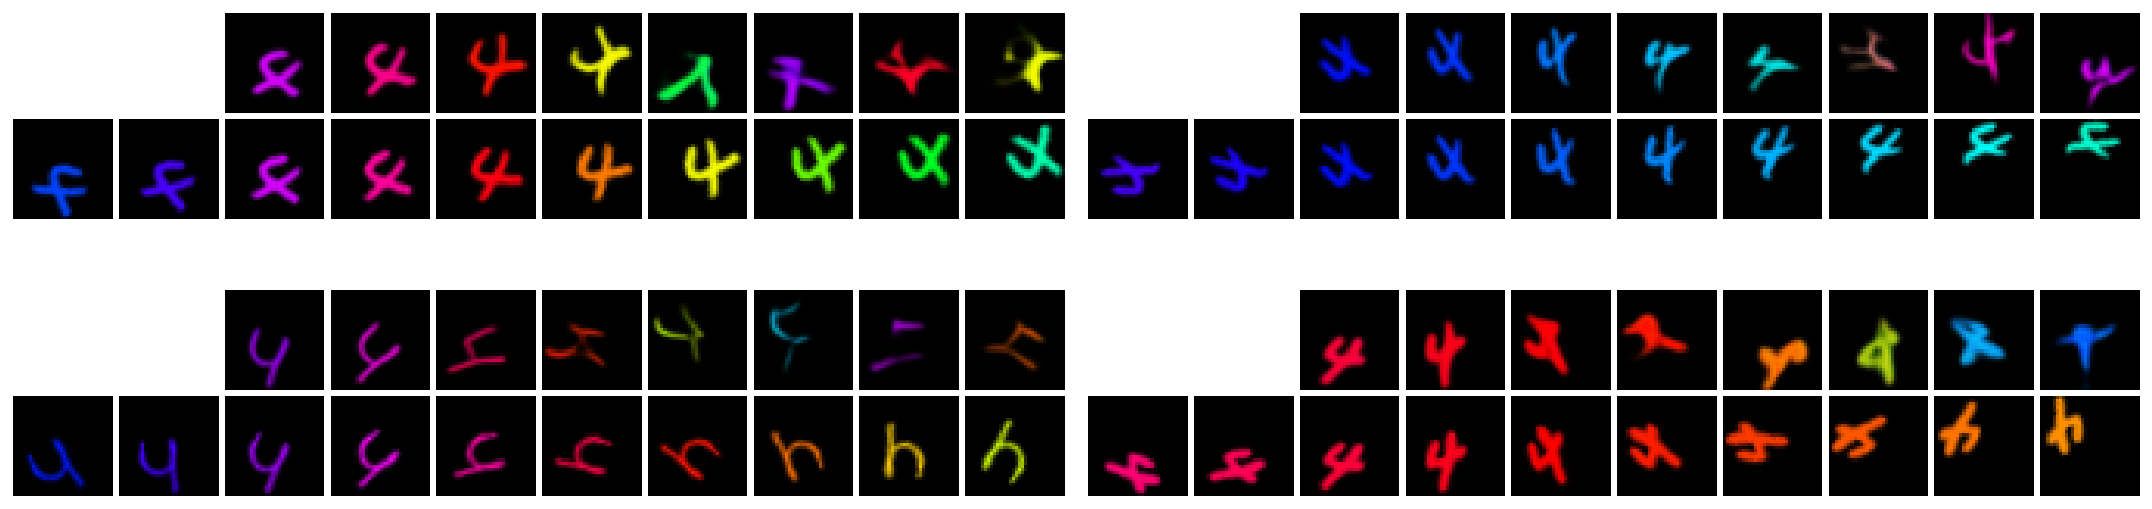

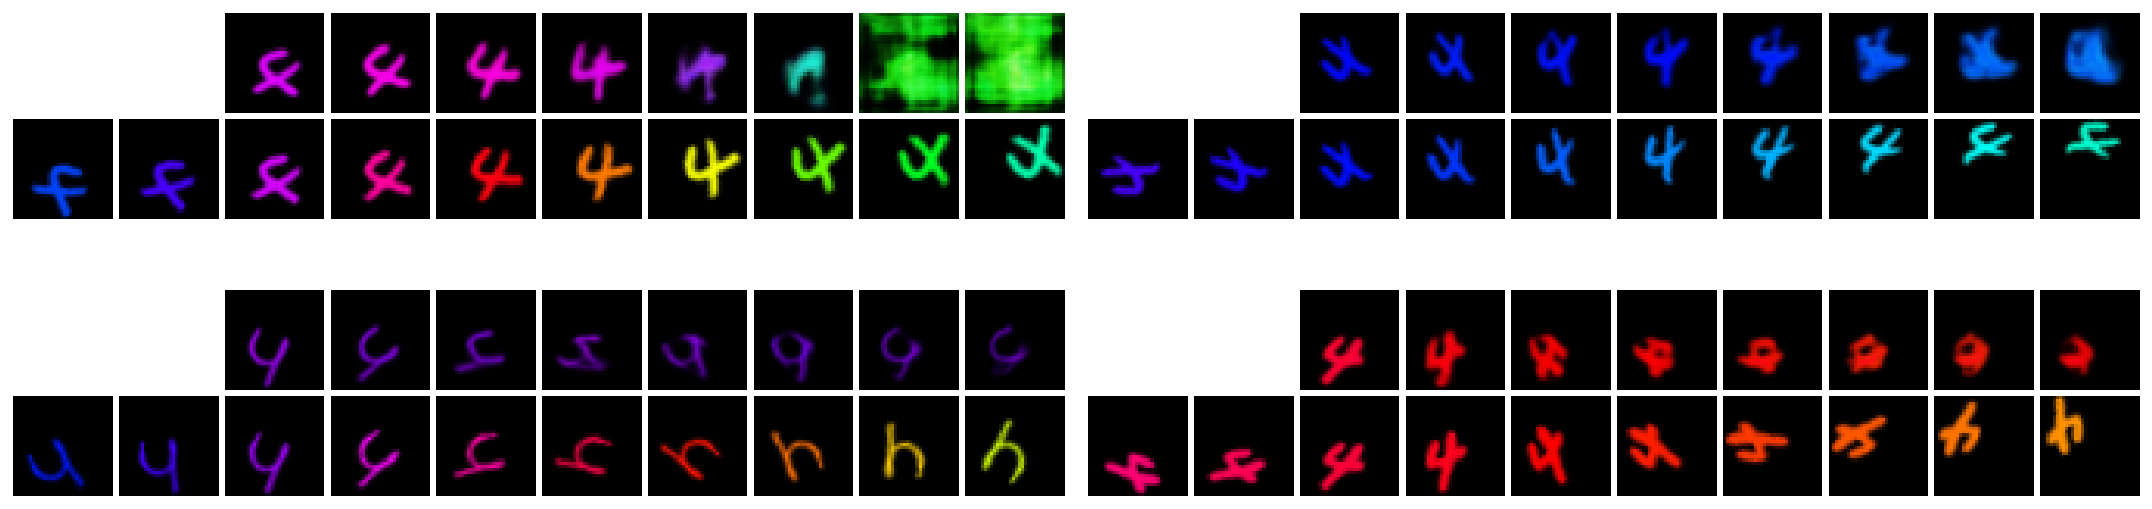

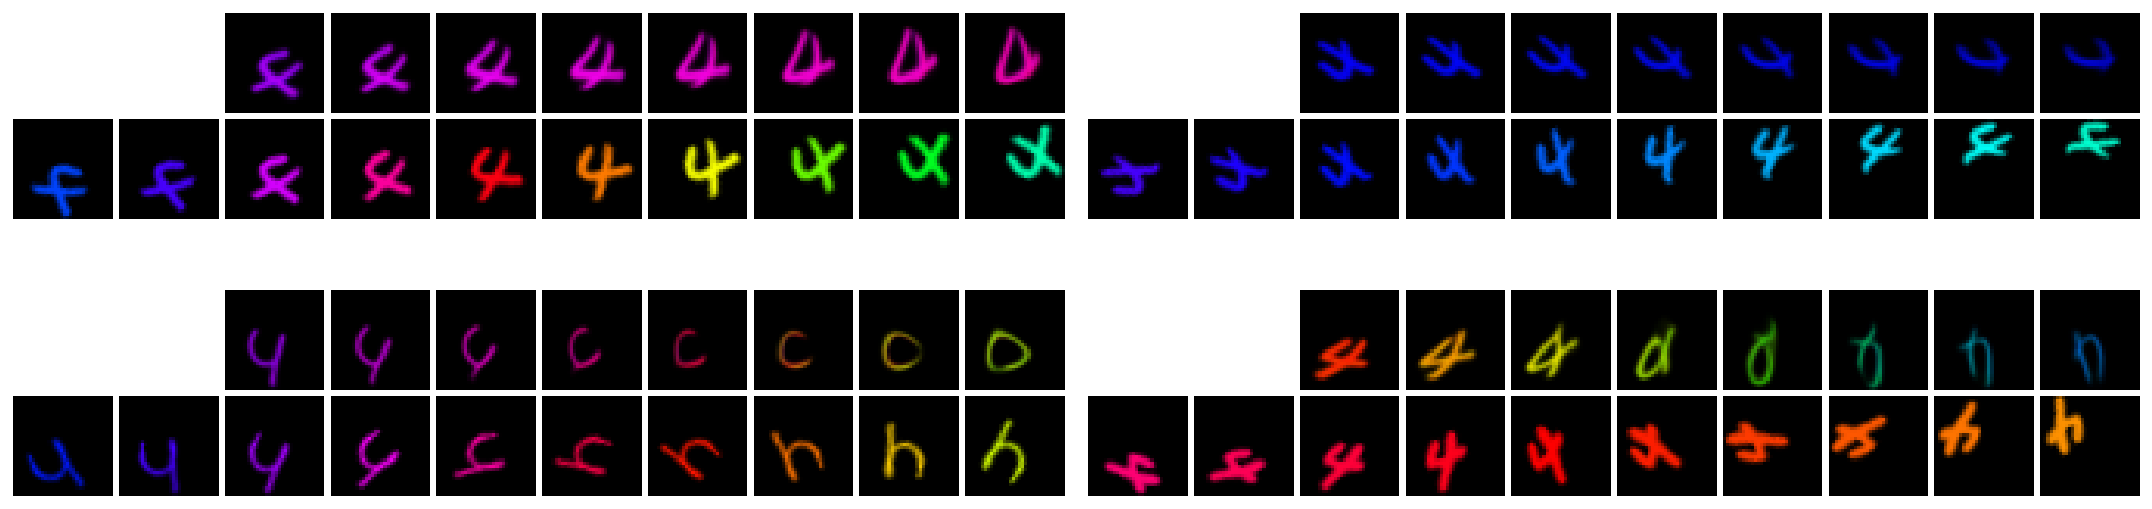

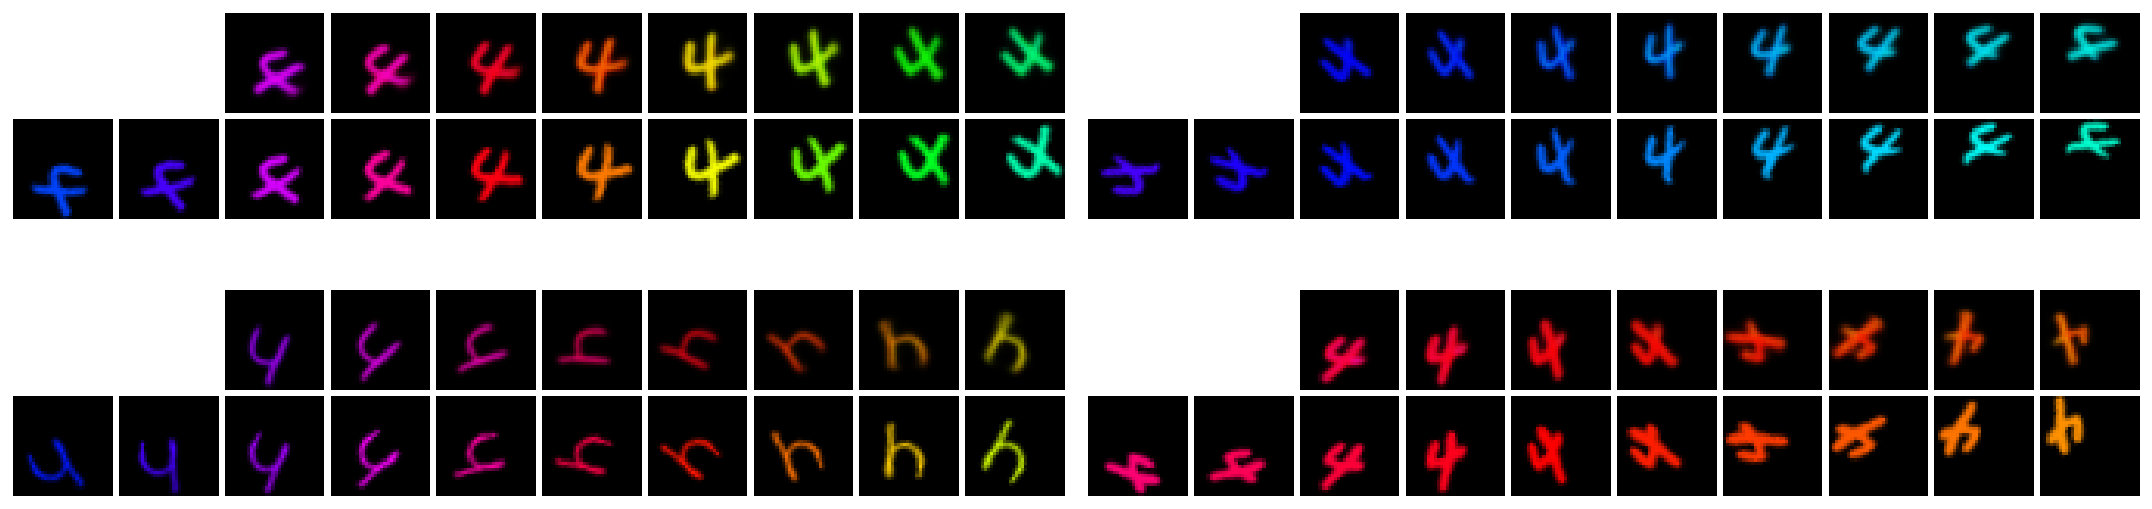

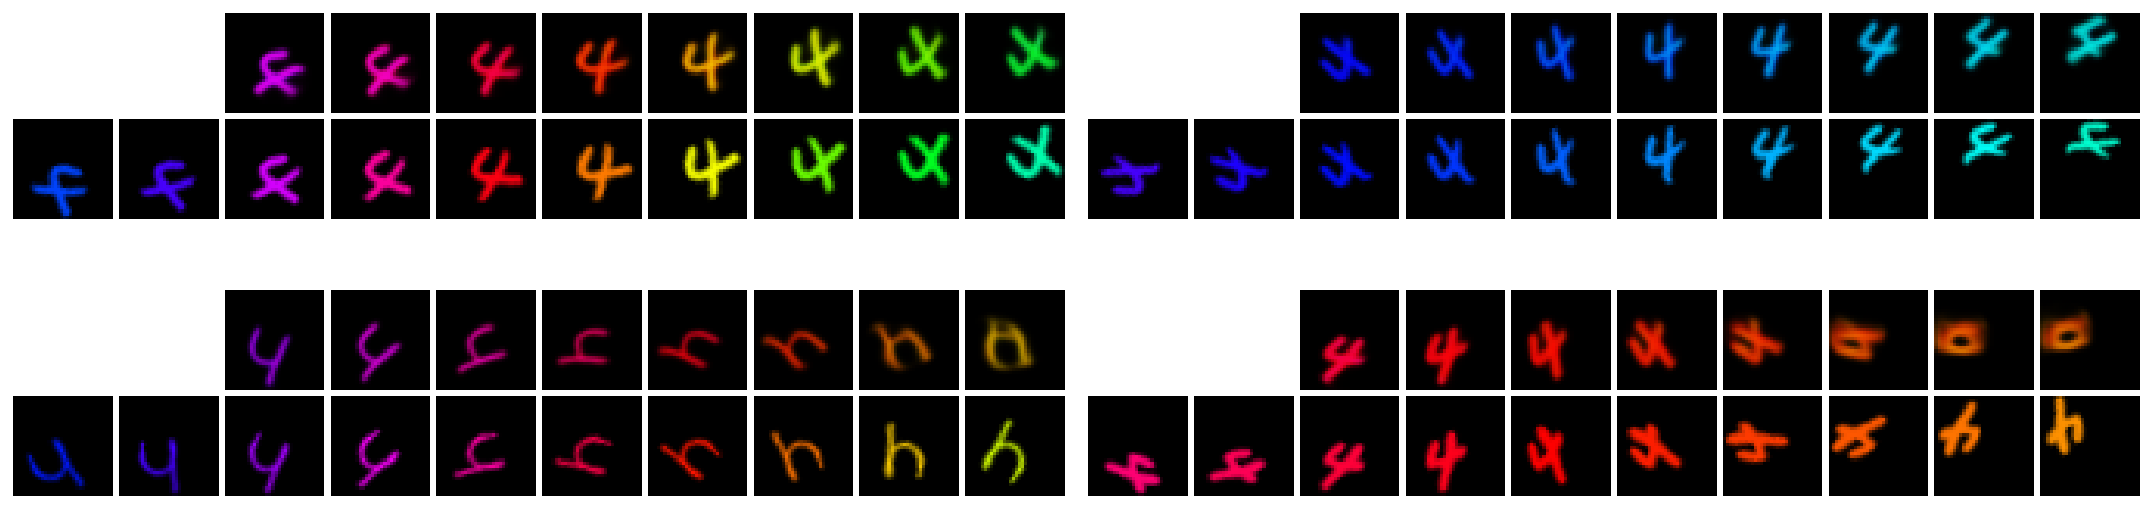

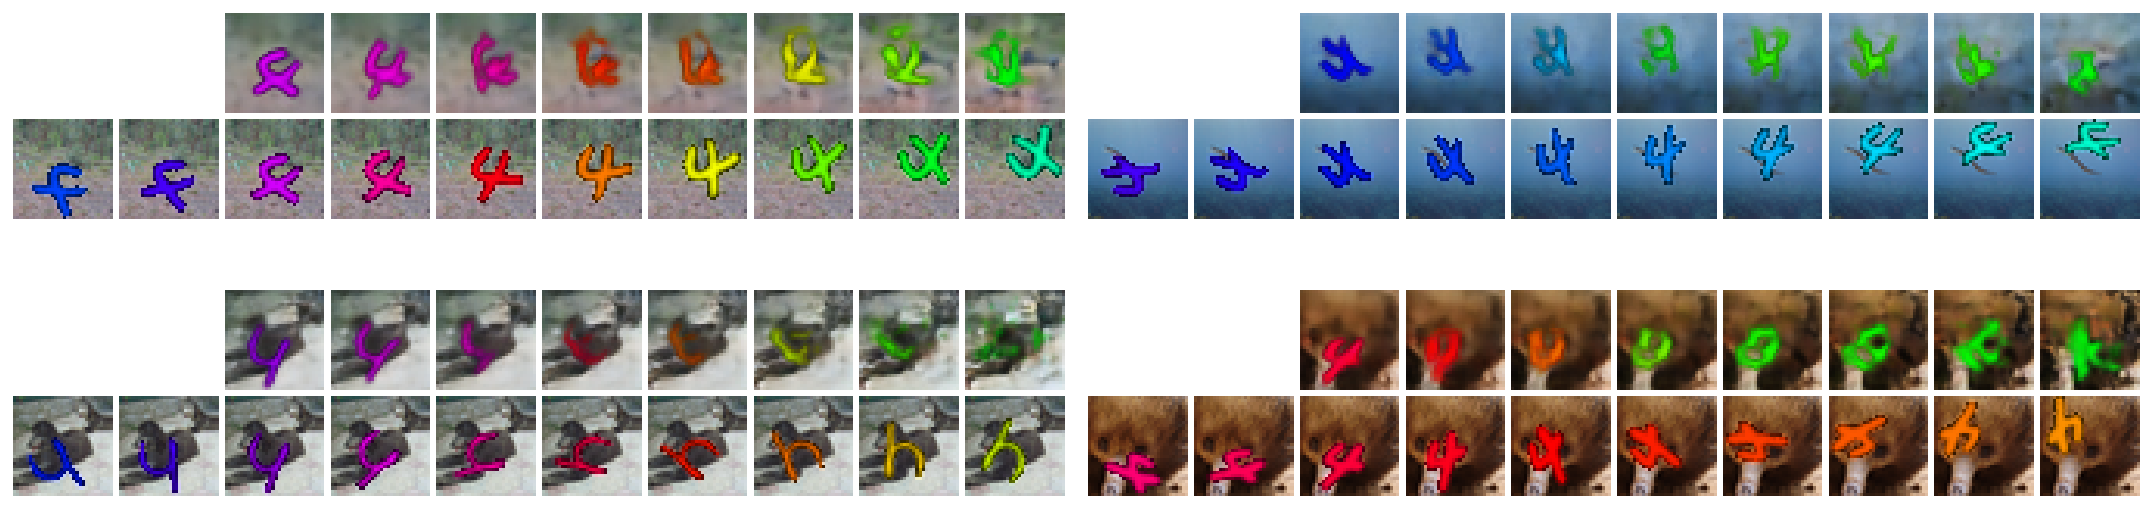

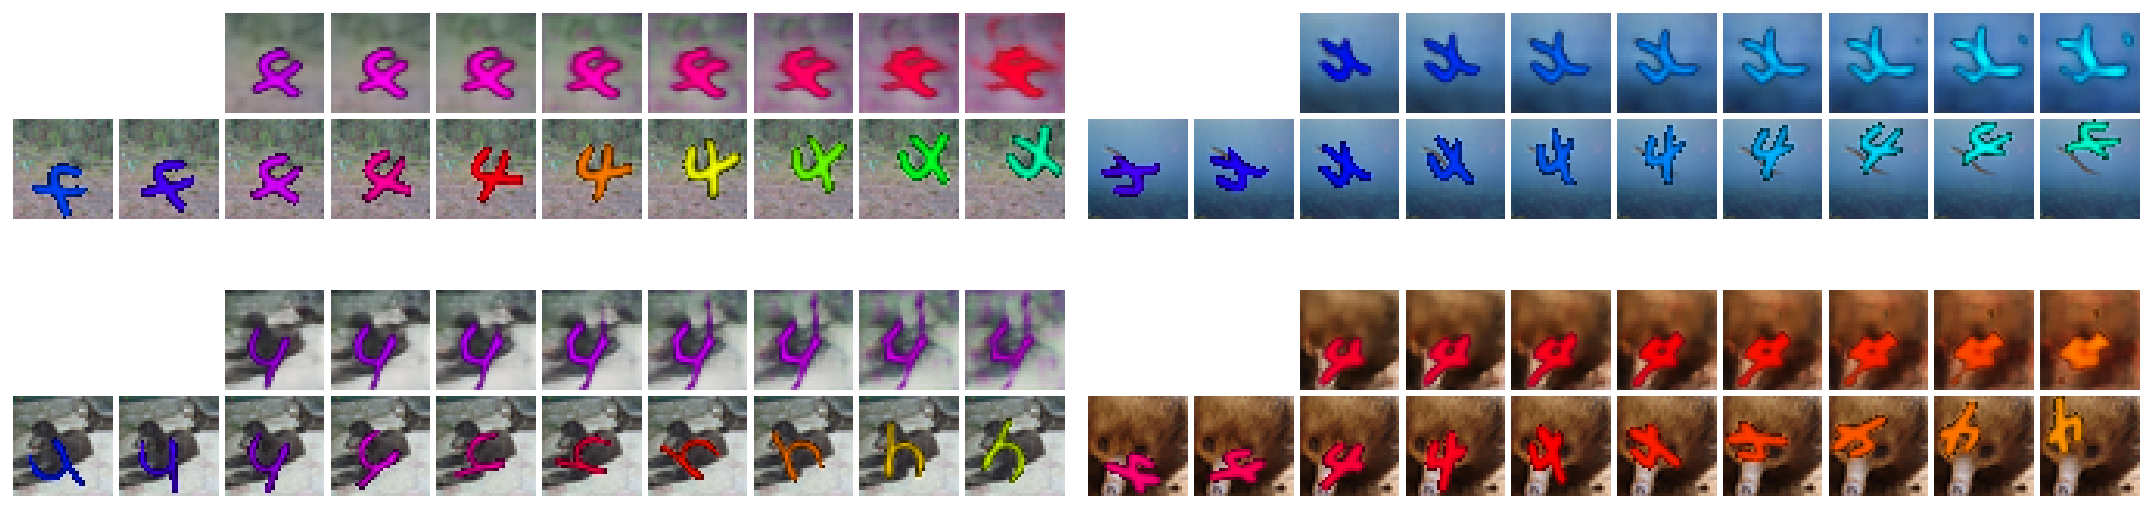

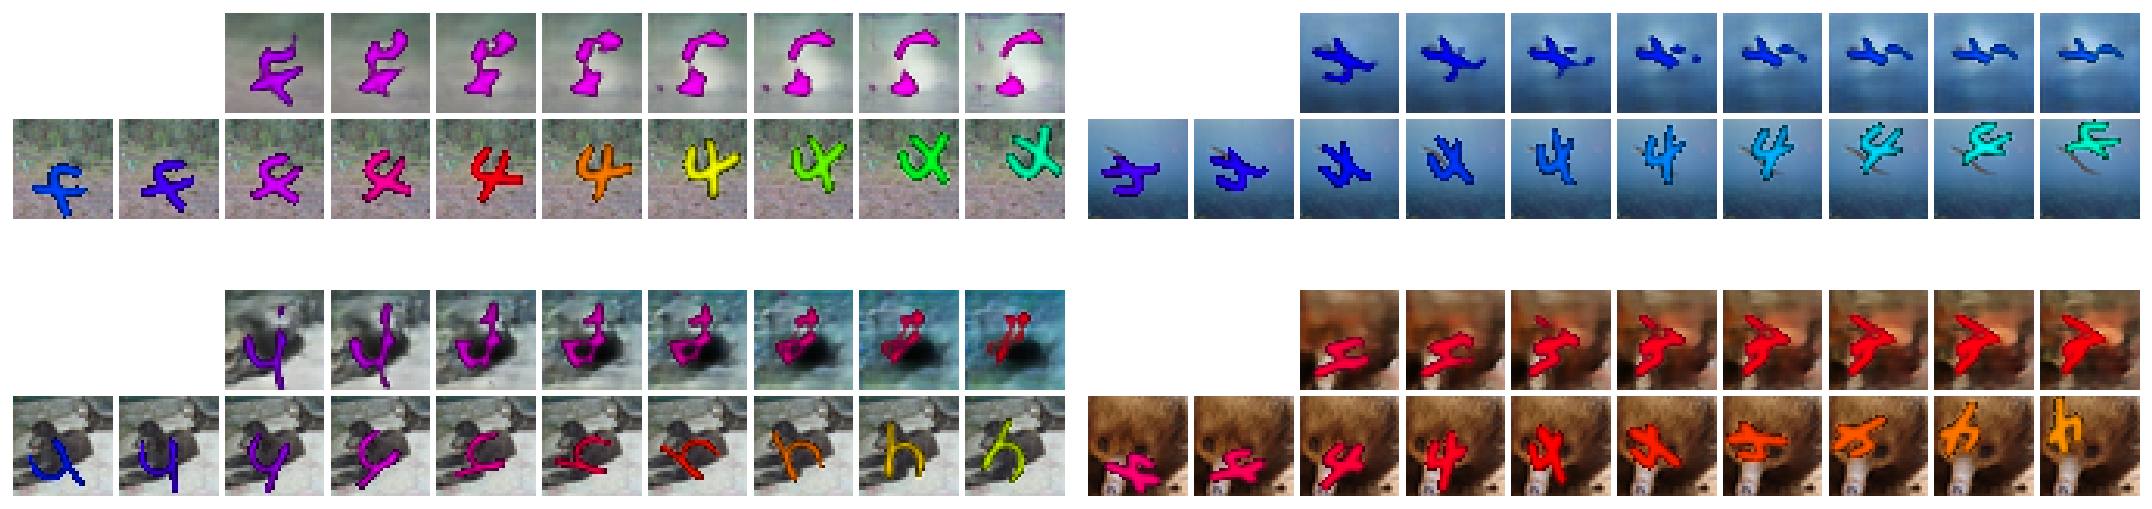

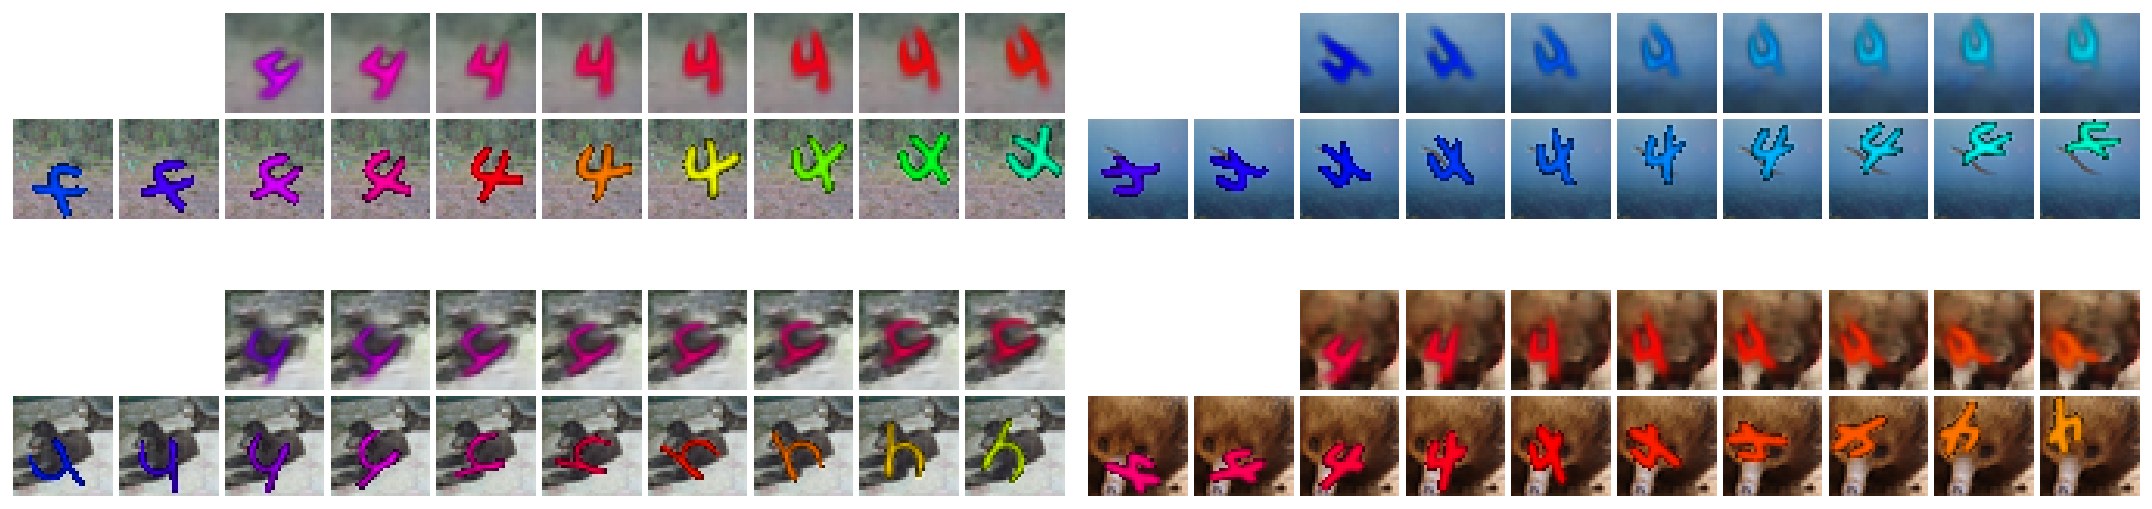

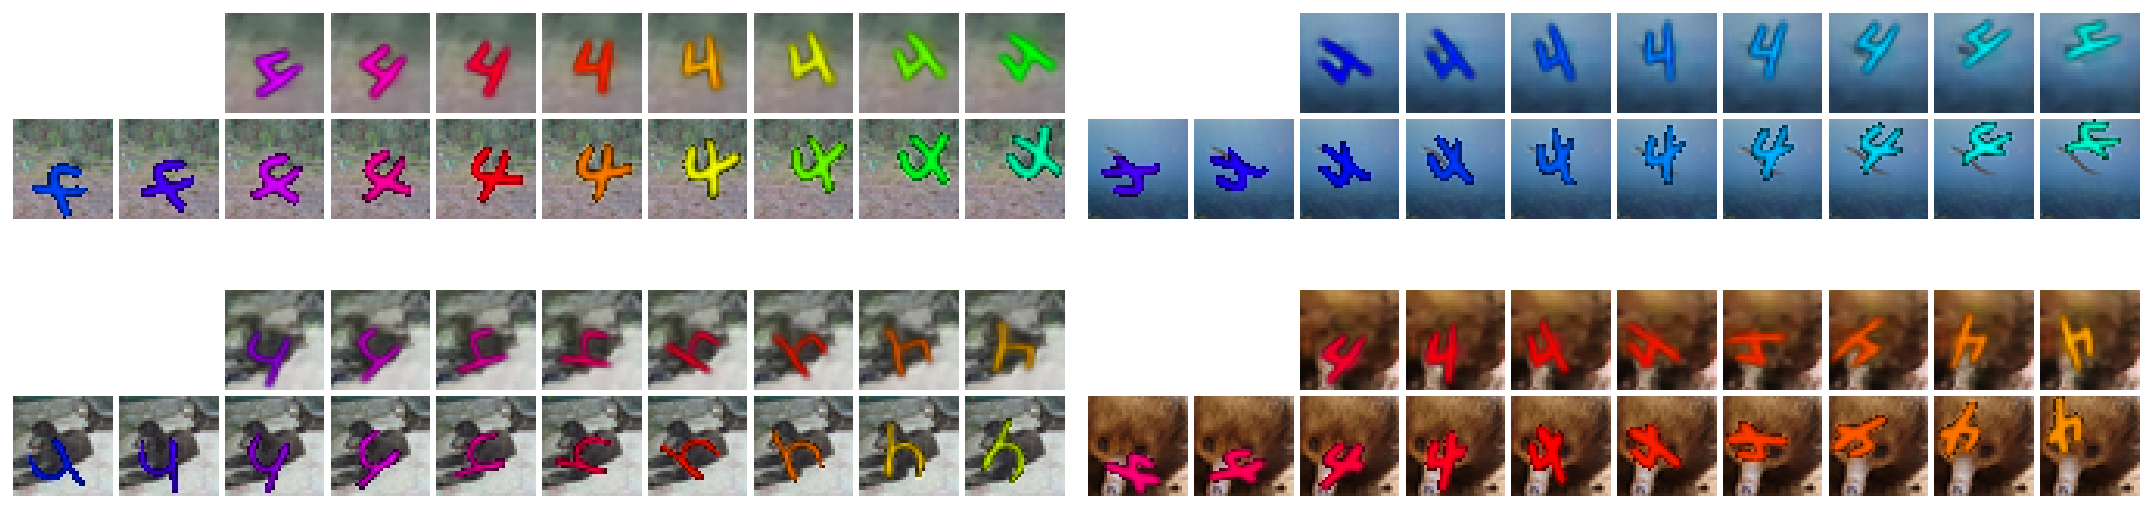

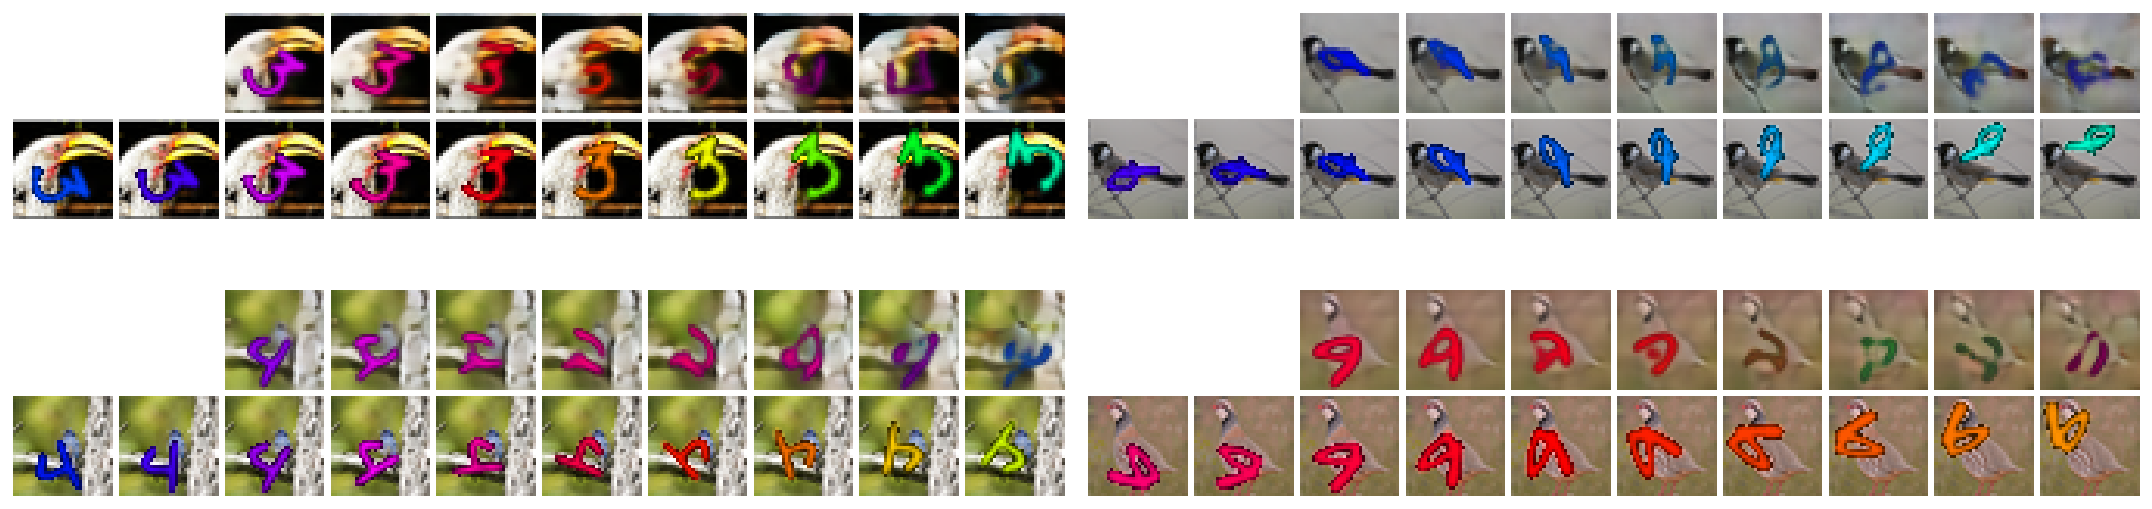

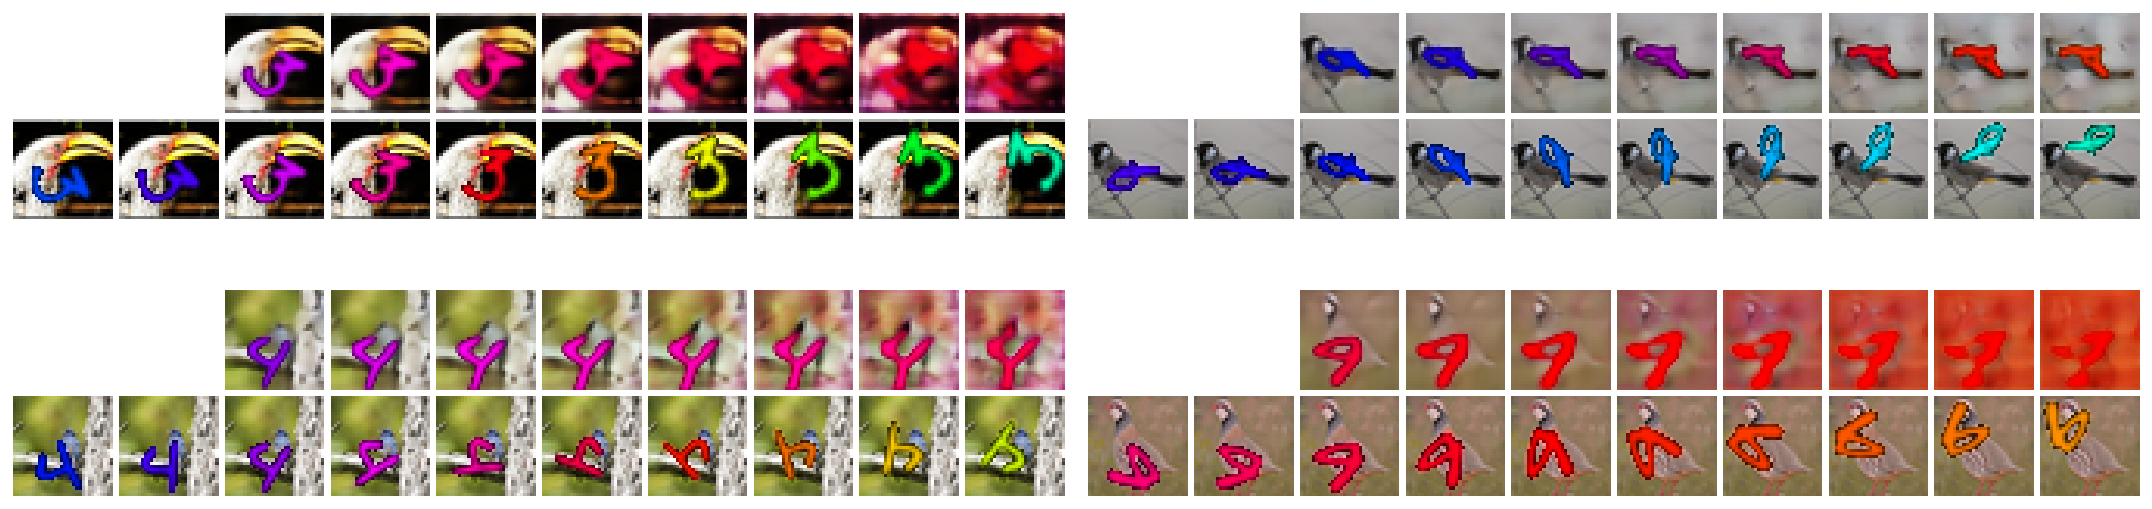

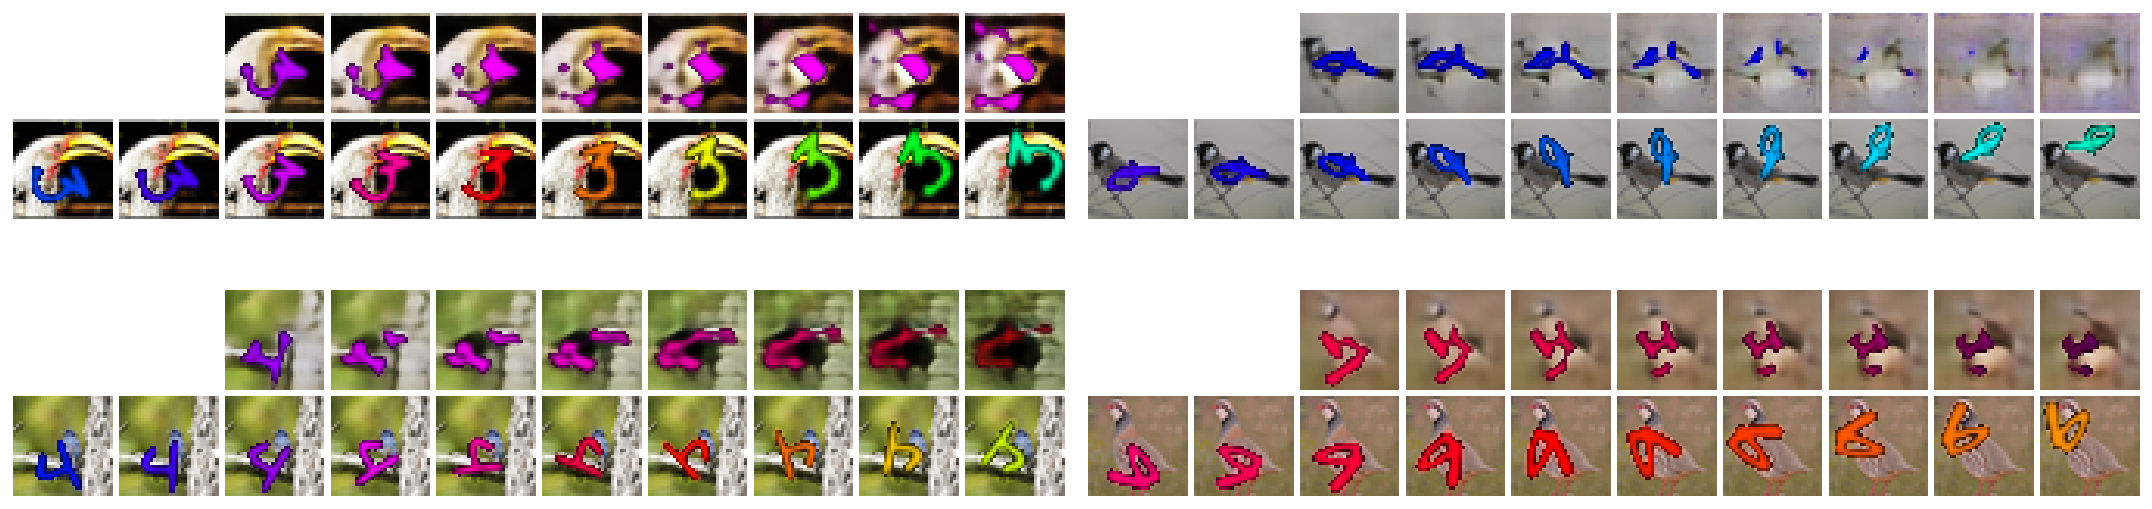

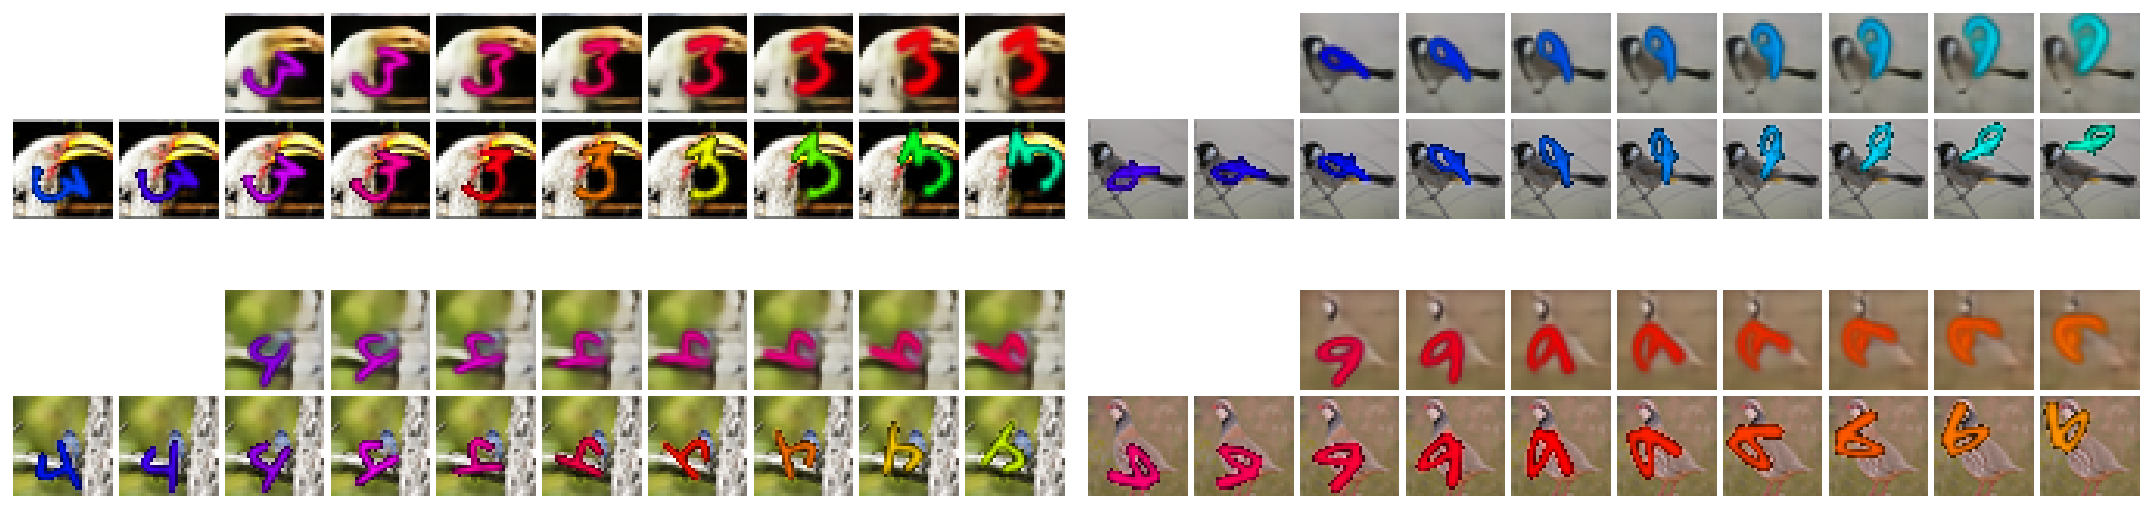

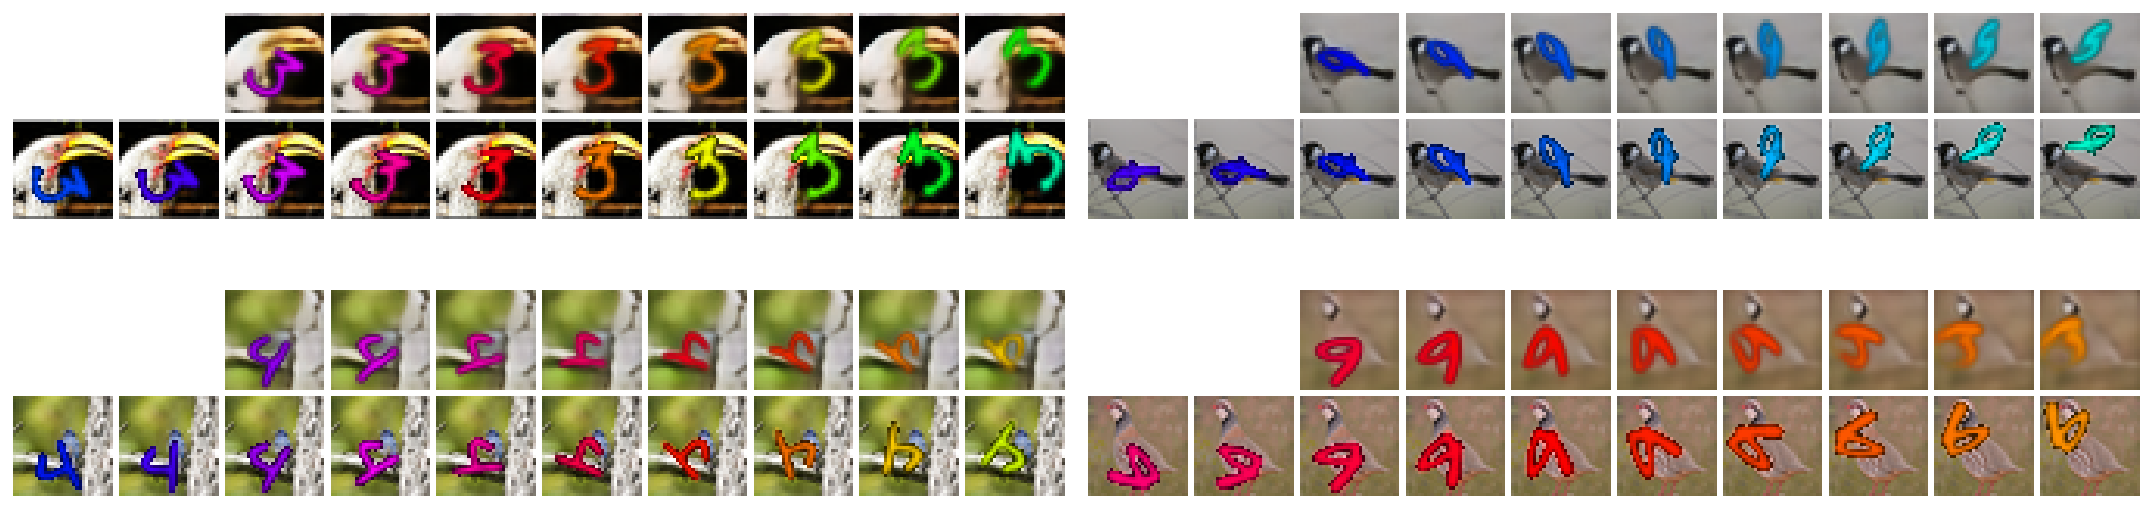

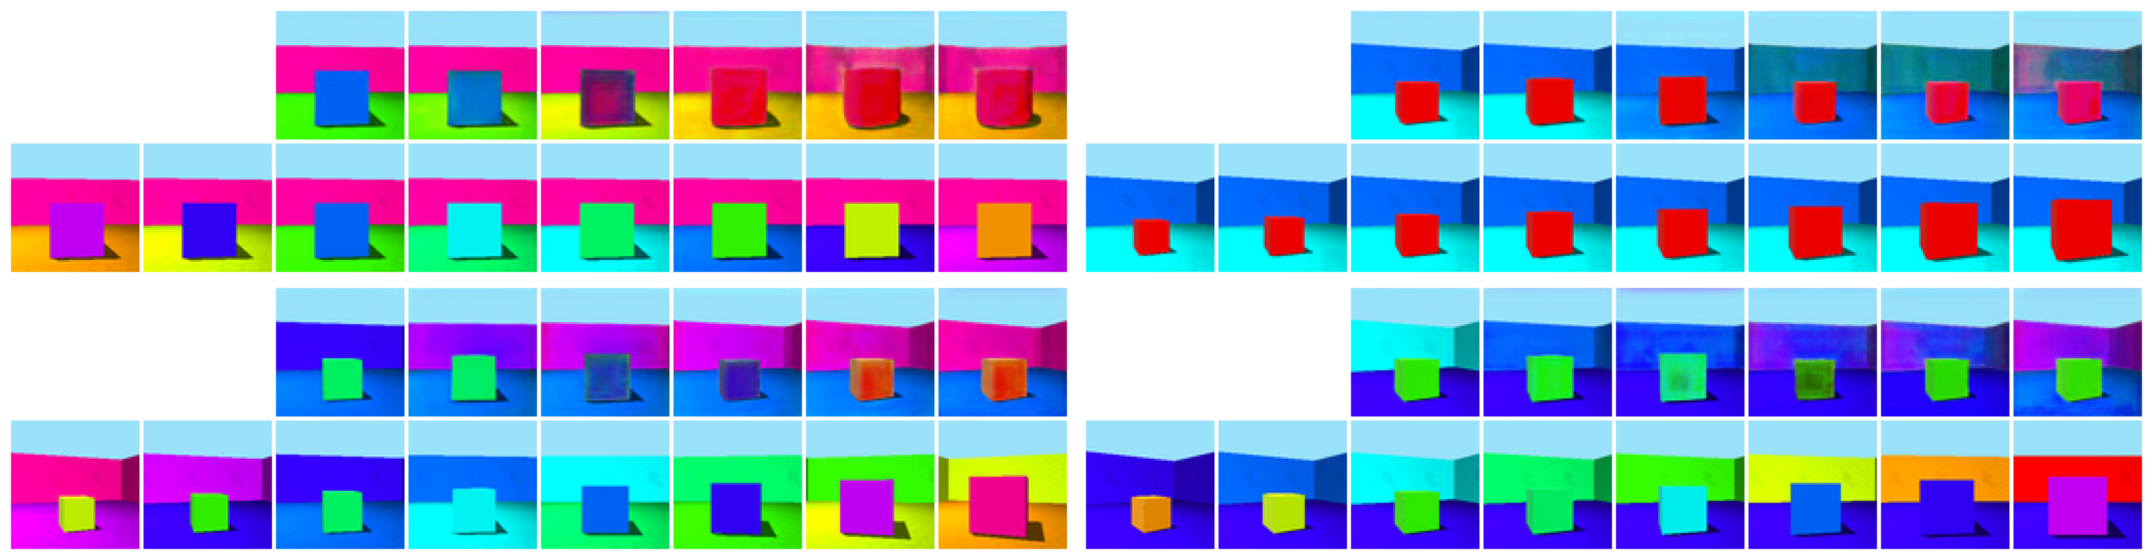

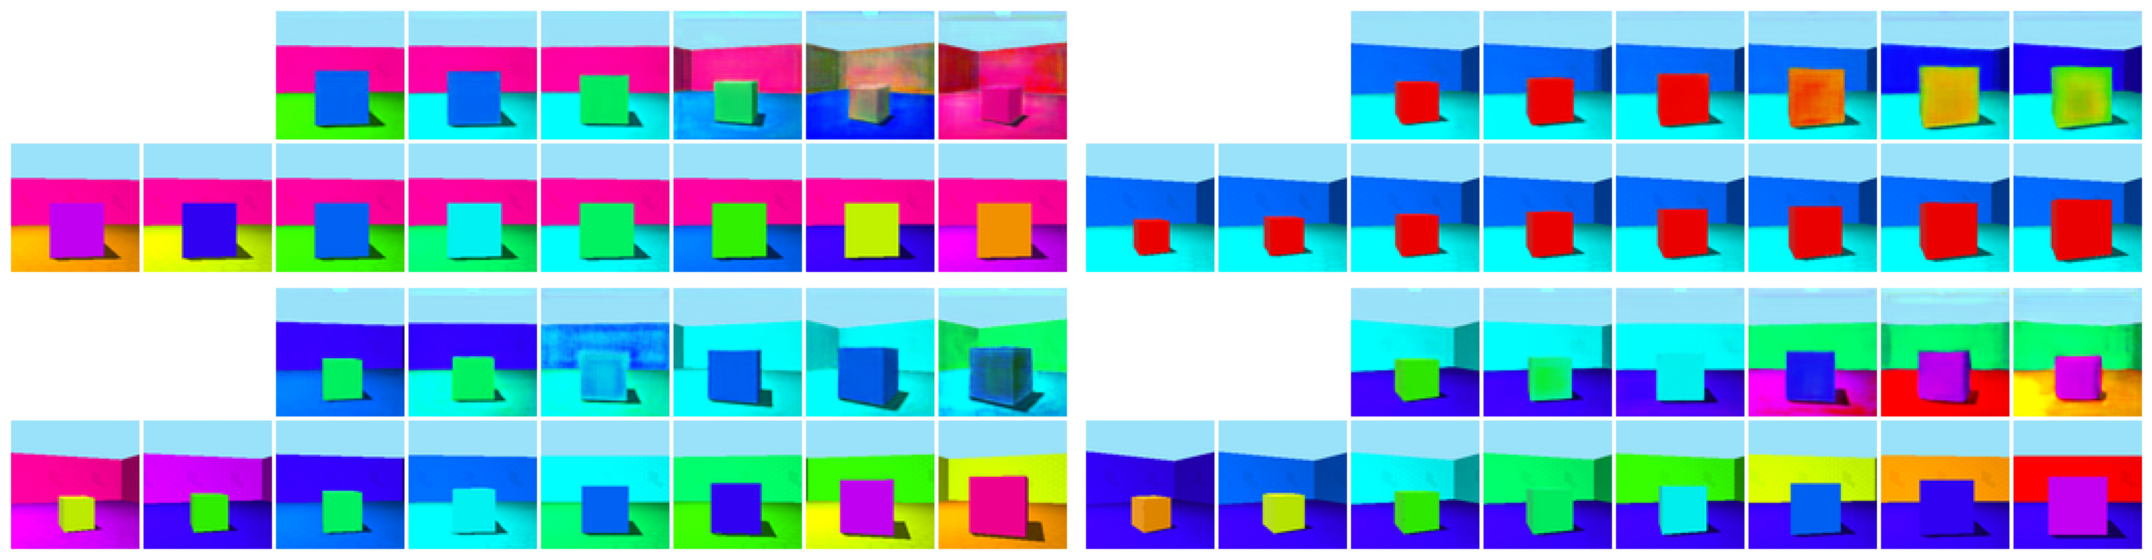

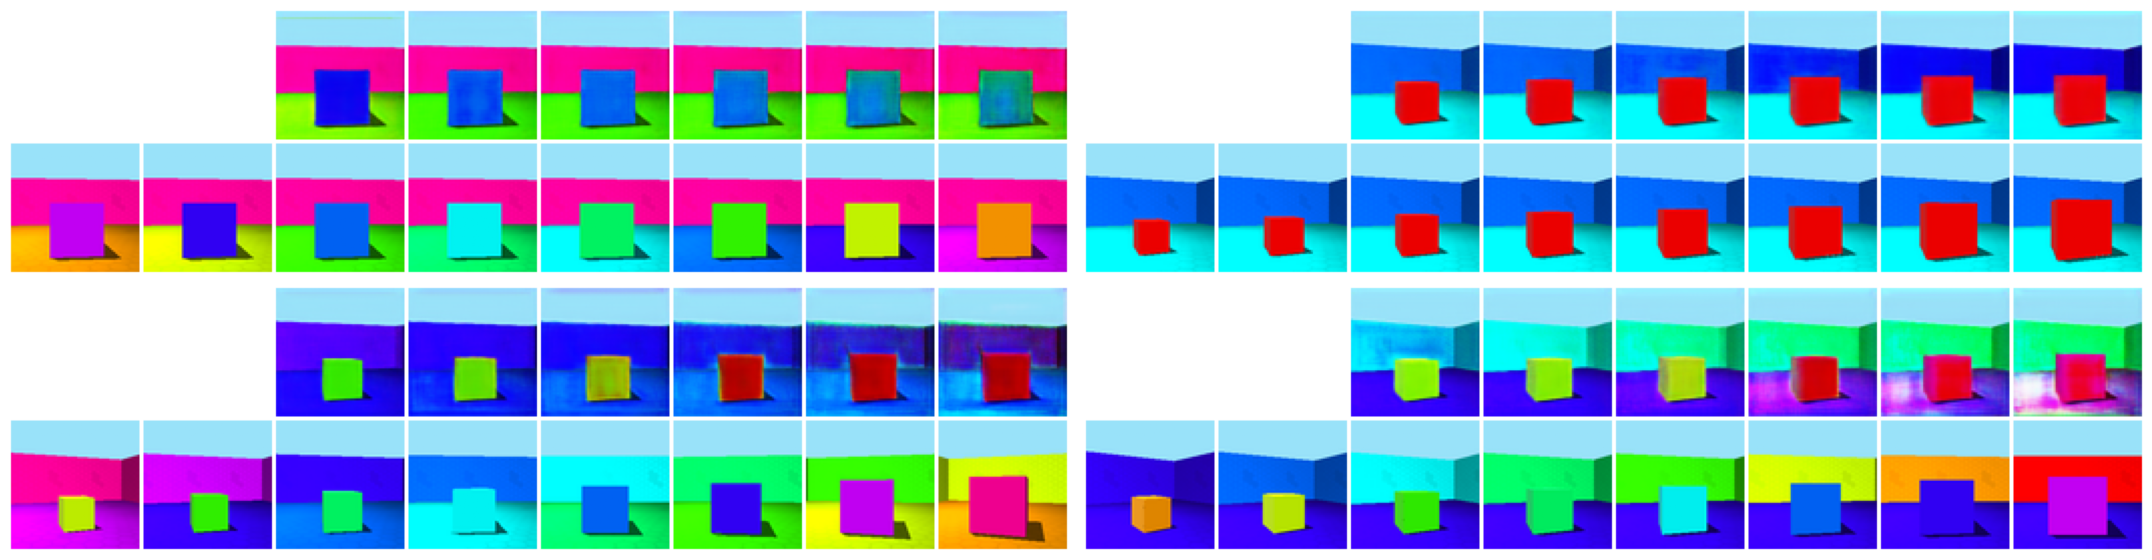

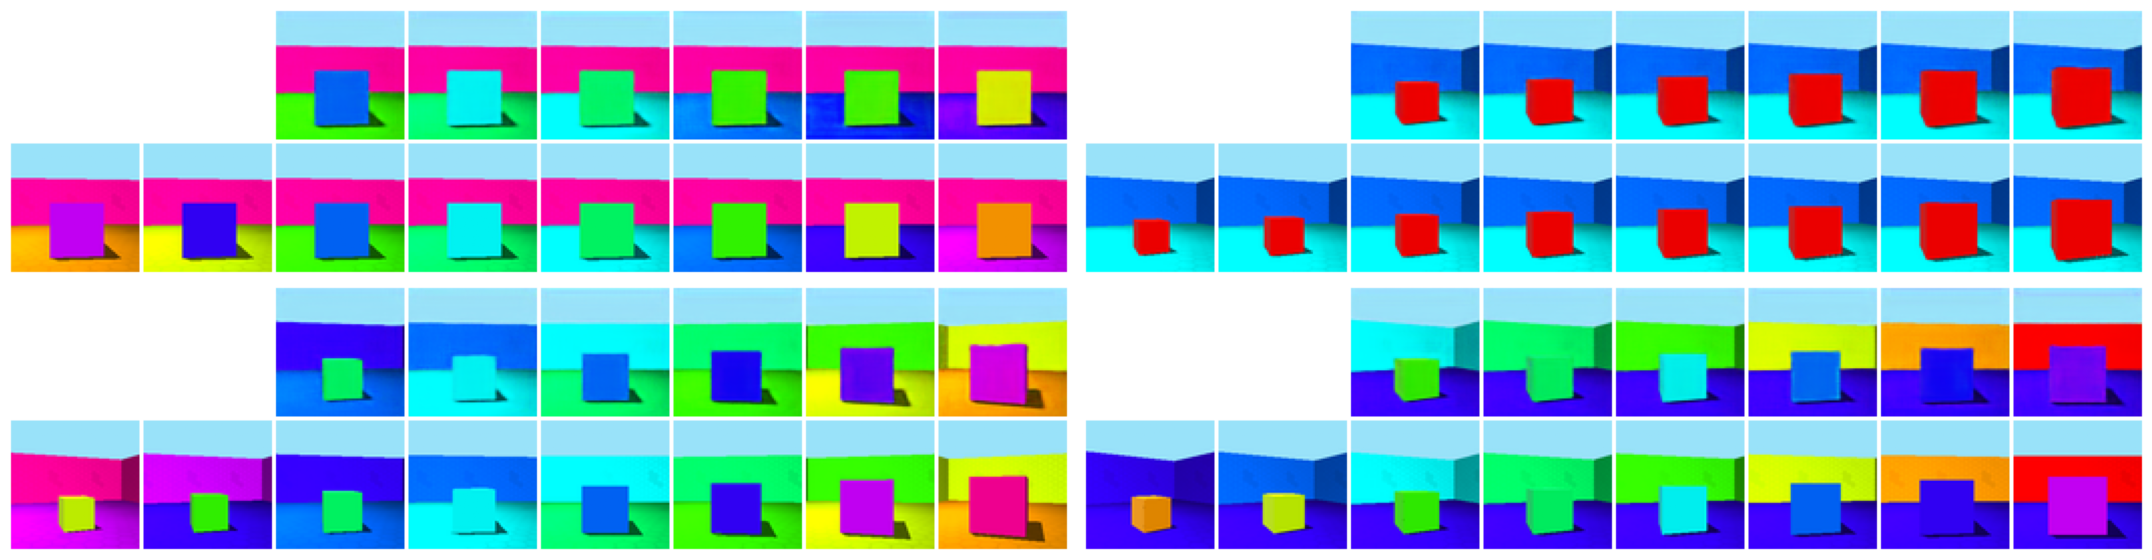

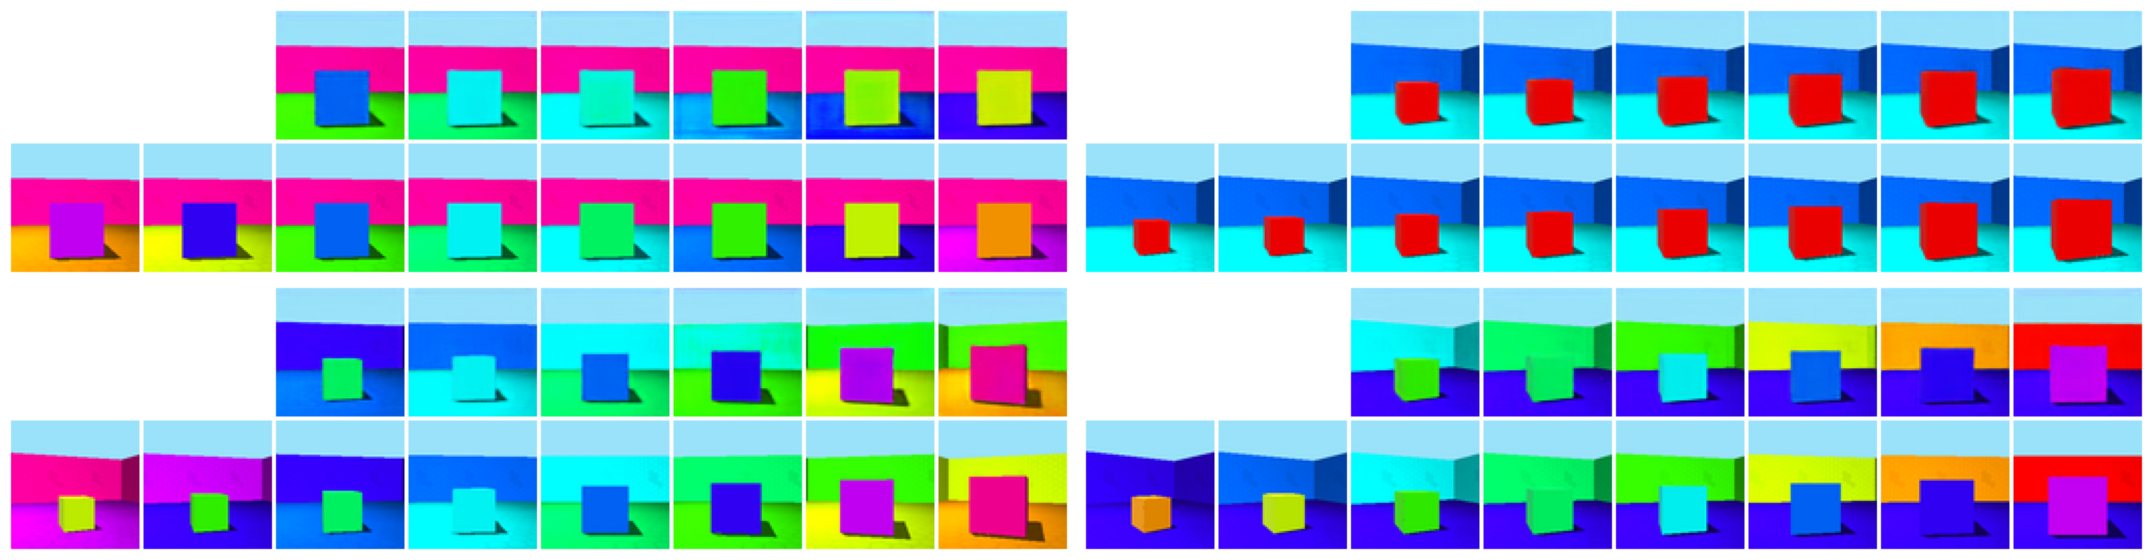

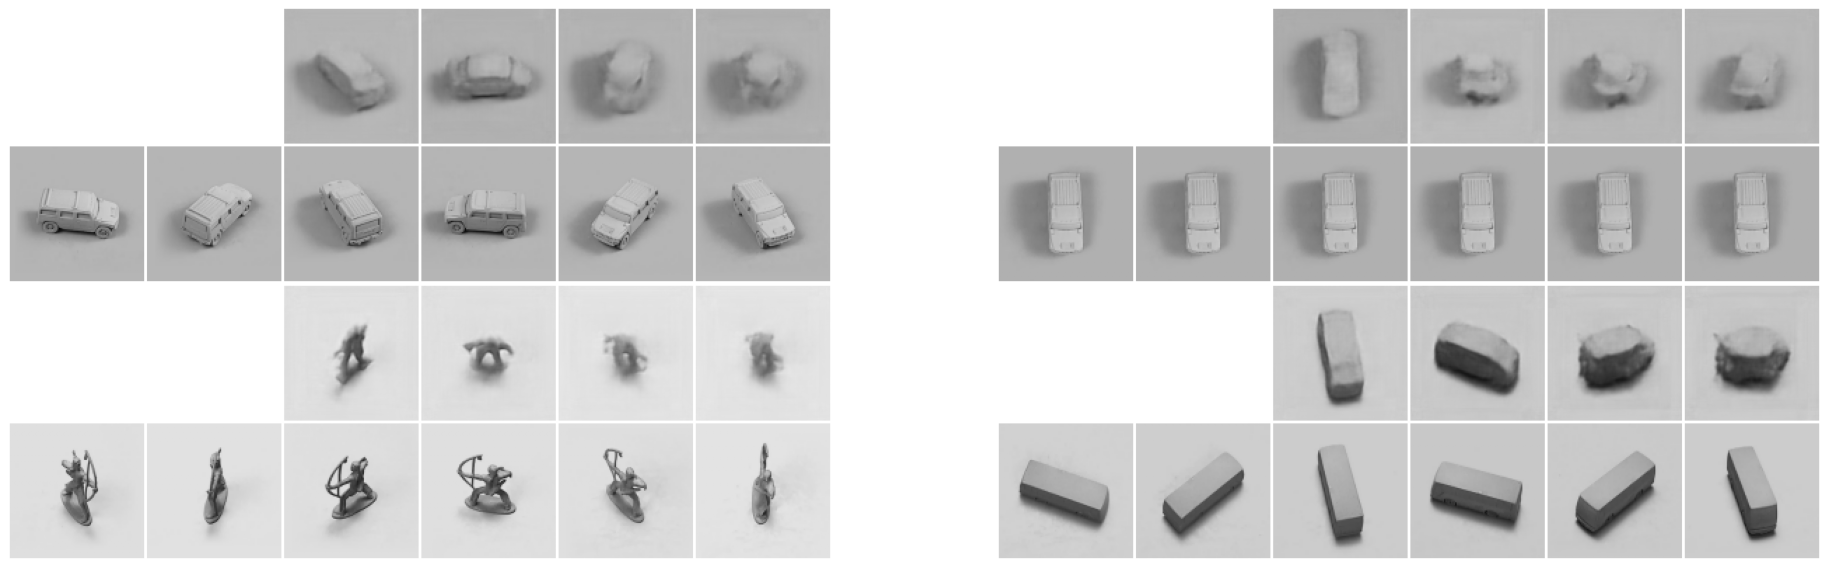

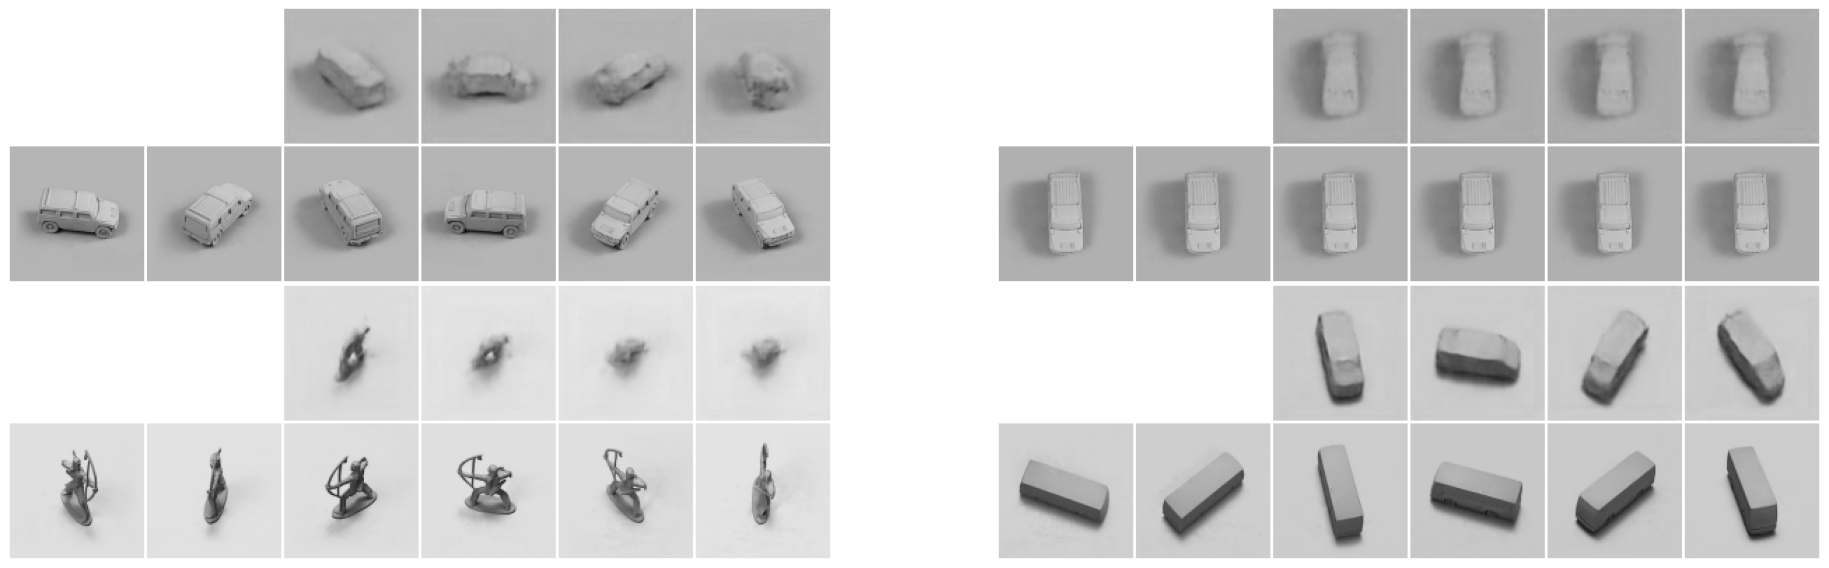

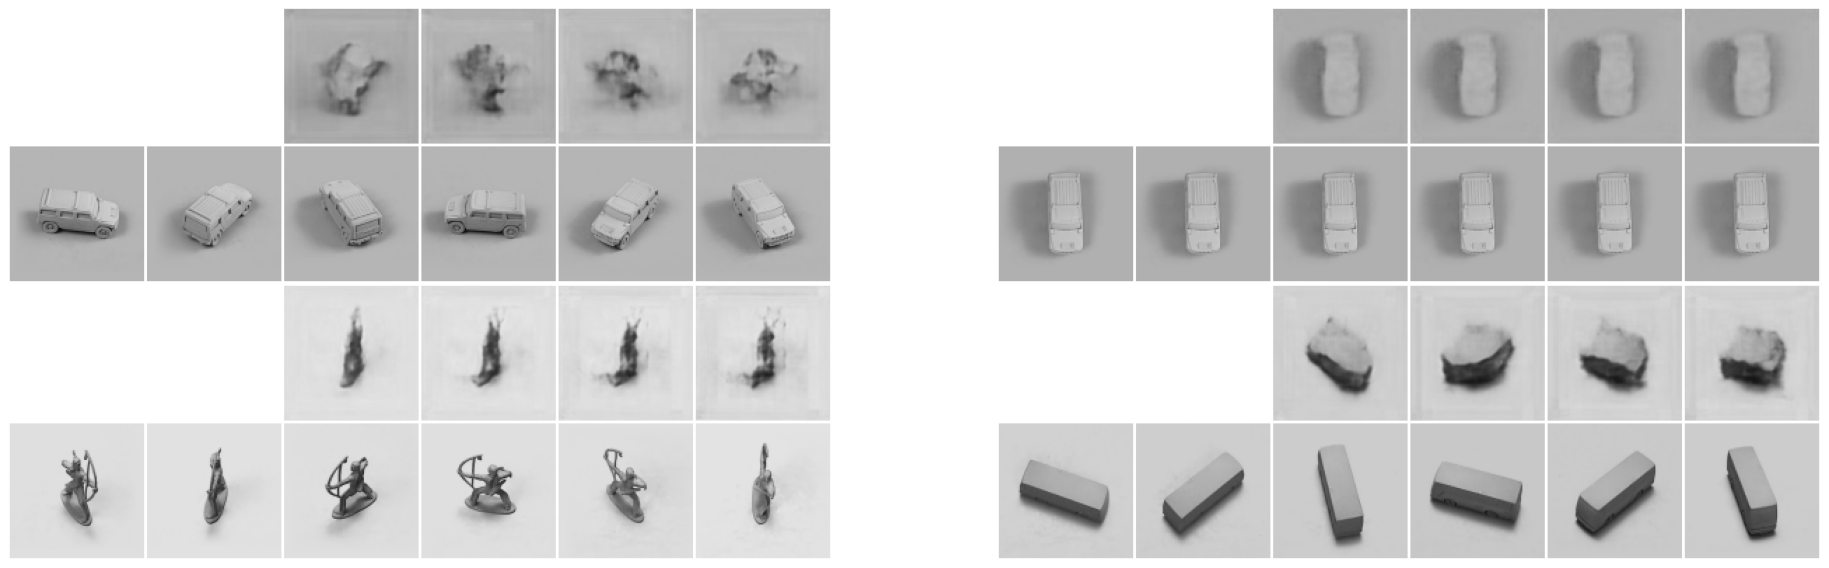

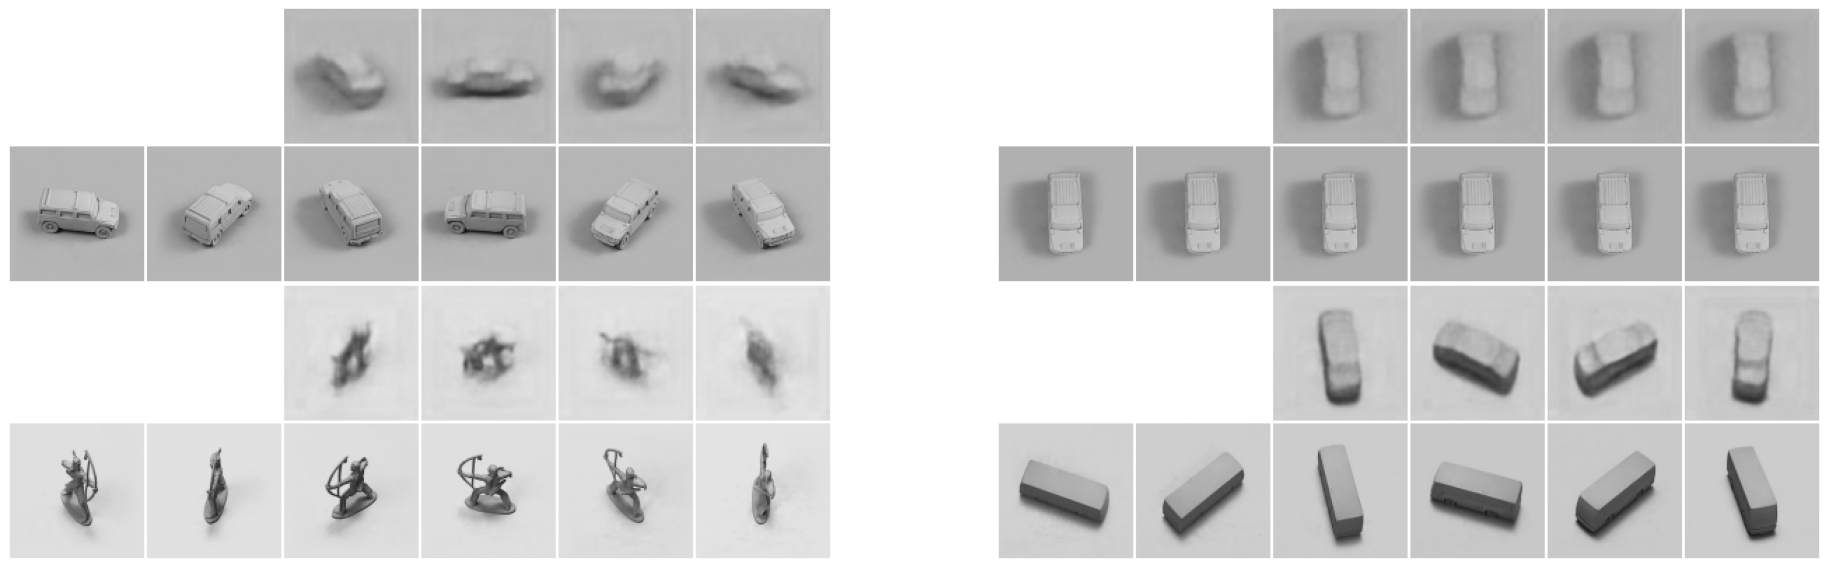

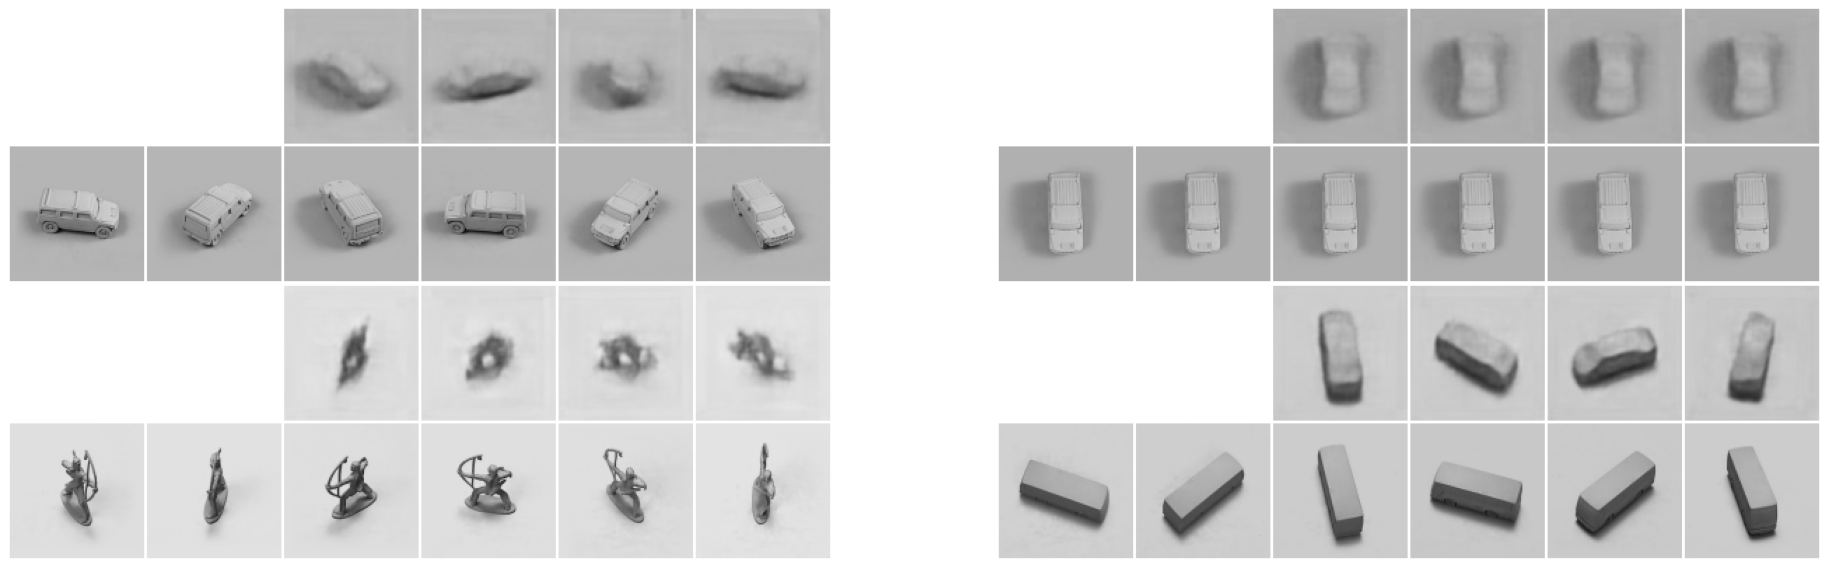

In [6]:

!mkdir gen_images
n_cond = 2
dataset_names = ['mnist', 'mnist_bg', 'mnist_bg_full', '3dshapes', 'smallNORB']
model_names = ['neural_trans', 'neuralM', 'lstsq_rec', 'lstsq_multi', 'lstsq']
for dataset_name in dataset_names:
    if dataset_name == 'mnist':
        T = 10
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False)
    elif dataset_name == 'mnist_bg':
        T = 10
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=True)
    elif dataset_name == 'mnist_bg_full':
        T = 10
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=False,
            backgrnd=True)
    elif dataset_name == '3dshapes':
        T = 8
        test_data = ThreeDimShapesDataset(
            root=datadir_root,
            train=True, T=T)
    elif dataset_name == 'smallNORB':
        T = 6
        test_data = SmallNORBDataset(
            root=datadir_root,
            train=False,
            T=T)
    else:
        raise NotImplementedError
    
    n_rolls = T - n_cond
    
    for model_name in model_names:
        print(dataset_name, model_name)
        path = os.path.join(logdir_root, "{}-{}-seed{}".format(dataset_name, model_name, 1))
        config = load_config(os.path.join(path, 'config.yml'))
        model = yu.load_component(config['model'])
        model.to(device)
        load_model(model, path, iters=config['max_iteration'])
        model.eval()
        
        model.eval()
        with torch.no_grad():
            init_random_seed()
            test_data.rng= np.random.RandomState(1234)
            test_loader = DataLoader(test_data, 4, True, num_workers=0)
            images = iter(test_loader).next()
            images = torch.stack(images).transpose(1, 0)
            images = images.to(device)
            images_cond, images_target = images[:, :n_cond], images[:, n_cond:n_cond+n_rolls]
            images_pred = model(images_cond, n_rolls=n_rolls)
            save_images(images_cond, images_target, images_pred, fname=dataset_name+'_'+model_name, n_col=2)
